In [2]:
import lab2_setup
import numpy as np
import sympy
import time

#####################
Qc = 1
R = np.diag([0.1, 0.1, 0.1, 0.1, 0.1])
#####################

dt = 0.01
nx = 6
ny = 5
ntime = 1000

phi, p, theta, q, psi, r = sympy.symbols('phi, p, theta, q, psi, r')
f = sympy.Matrix([
    p + sympy.sin(phi)*sympy.tan(theta)*q + sympy.cos(phi)*sympy.tan(theta)*r,
    0.0,
    sympy.cos(phi)*q - sympy.sin(phi)*r,
    0.0,
    sympy.sin(phi)*sympy.sec(theta)*q + sympy.cos(phi)*sympy.sec(theta)*r,
    0.0
])

A = f.jacobian([phi, p, theta, q, psi, r])
A_func = sympy.lambdify([phi, p, theta, q, psi, r], A, modules=['numpy', {'sec':sympy.sec}])
f = sympy.lambdify([phi, p, theta, q, psi, r], A, modules=['numpy', {'sec':sympy.sec}])

h = sympy.Matrix([phi, p, theta, q, r])
h_func = sympy.lambdify([phi, p, theta, q, psi, r], h, modules=['numpy', {'sec':sympy.sec}])

C = h.jacobian([phi, p, theta, q, psi, r])
C_func = sympy.lambdify([phi, p, theta, q, psi, r], C, modules=['numpy', {'sec':sympy.sec}])


x = sympy.Matrix([phi, p, theta, q, psi, r])
x0 = np.array([[0.0,0.0,0.0,0.0,0.0,0.0]]).T

V = Qc * np.array([[1/3*dt**3,1/2*dt**2,0,0,0,0],
                    [1/2*dt**2, dt, 0, 0,0,0],
                    [0,0,1/3*dt**3,1/2*dt**2,0,0],
                    [0,0,1/2*dt**2, dt,0,0],
                    [0,0,0,0,1/3*dt**3,1/2*dt**2],
                    [0,0,0,0,1/2*dt**2, dt]])

Q0 = V




imu = lab2_setup.IMU()




In [13]:
xh = np.empty((nx,1,ntime))
Qh = np.empty((nx,nx,ntime))

i = 0
xkk = x0
Qkk = Q0
xh[:,:,i] = x0
Qh[:,:,i] = Q0
g = 9.8


while i<ntime-1:
    i += 1
    # propogate statistics
    xkkm1 = xkk + dt*A_func(xkk[0,0],xkk[1,0],xkk[2,0],xkk[3,0],xkk[4,0],xkk[5,0])@xkk
    Qkkm1 = Qkk + dt*(A_func(xkk[0,0],xkk[1,0],xkk[2,0],xkk[3,0],xkk[4,0],xkk[5,0])@Qkk
                        + Qkk@A_func(xkk[0,0],xkk[1,0],xkk[2,0],xkk[3,0],xkk[4,0],xkk[5,0]).T
                        + V)
    Qkkm1 = Qkkm1.astype(np.float64)

    # get measurement
    y = np.zeros((5,1))
    acc = imu.get_acc()
    gyr = imu.get_gyr()
    if np.abs(acc[0]/g) > 1.0:
        y[0] = 0
    else:
        y[0] = np.arcsin(acc[0]/g)
    y[2] = np.arctan(acc[1]/acc[2])
    y[1] = gyr[0]
    y[3] = gyr[1]
    y[4] = gyr[2]

    # update estimate using measurement
    Ck = C_func(xkk[0,0],xkk[1,0],xkk[2,0],xkk[3,0],xkk[4,0],xkk[5,0]).astype(np.float64)
    Lk = Qkkm1@Ck.T@np.linalg.inv(Ck@Qkkm1@Ck.T + R)
    xkk = xkkm1 + Lk@(y - h_func(xkk[0,0],xkk[1,0],xkk[2,0],xkk[3,0],xkk[4,0],xkk[5,0]))
    xkk = xkk.astype(np.float64)
    Qkk = (np.eye(nx) - Lk@Ck)@Qkkm1

    xh[:,:,i] = xkk
    Qh[:,:,i] = Qkk
    

/tmp/ipykernel_203242/2046727842.py:28: RuntimeWarning: invalid value encountered in arcsin
  y[0] = np.arcsin(acc[0]/g)
/tmp/ipykernel_203242/2046727842.py:40: RuntimeWarning: invalid value encountered in cast
  xkk = xkk.astype(np.float64)
/tmp/ipykernel_203242/2046727842.py:19: RuntimeWarning: invalid value encountered in cast
  Qkkm1 = Qkkm1.astype(np.float64)


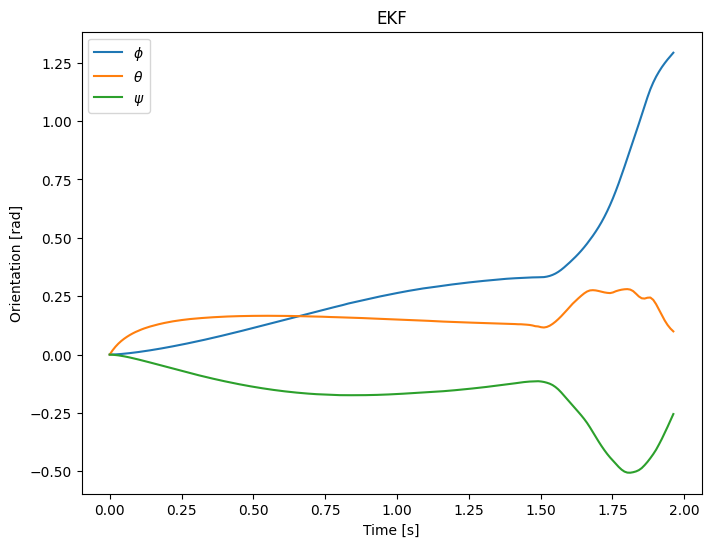

In [11]:
import matplotlib.pyplot as plt

t = np.linspace(0,ntime*dt,ntime)


plt.figure()
plt.plot(t,xh[0,0,:], label="$\phi$")
plt.plot(t,xh[1,0,:], label="$\\theta$")
plt.plot(t,xh[2,0,:], label="$\psi$")
plt.xlabel("Time [s]")
plt.title("EKF")
plt.ylabel("Orientation [rad]")
plt.legend()
plt.show()

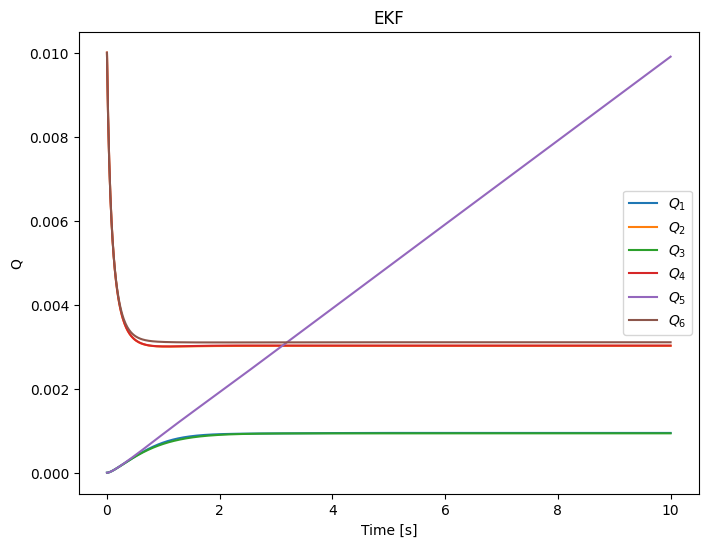

In [9]:
plt.figure()
plt.plot(t,Qh[0,0,:], label="$Q_1$")
plt.plot(t,Qh[1,1,:], label="$Q_2$")
plt.plot(t,Qh[2,2,:], label="$Q_3$")
plt.plot(t,Qh[3,3,:], label="$Q_4$")
plt.plot(t,Qh[4,4,:], label="$Q_5$")
plt.plot(t,Qh[5,5,:], label="$Q_6$")
plt.xlabel("Time [s]")
plt.title("EKF")
plt.ylabel("Q")
plt.legend()
plt.show()